# LSTM Model
Objective: Develop a LSTM Model to forecast total energy use.

## Load and Preview Data

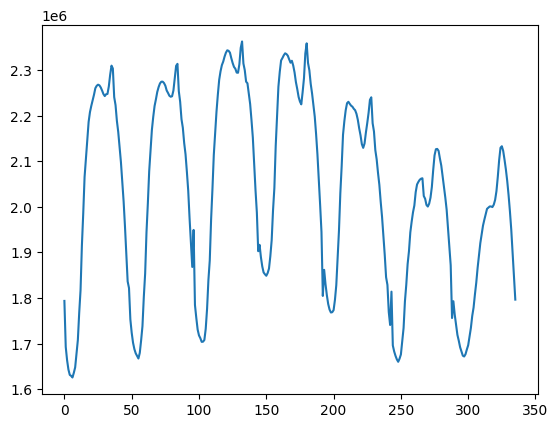

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./data/results/processed/semi_hourly_time_series.csv', header = 0)
timeseries = df[["Total_Energy"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

## Build Dataset

In [3]:
from sklearn.preprocessing import MinMaxScaler

# train test split - 2:1 split
train_size = int(len(timeseries)*0.56)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

# normalize data
scaler = MinMaxScaler()
scaler.fit(train)

train_norm = scaler.transform(train)
test_norm = scaler.transform(test)

import torch

# define dataset creation
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range (len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

#build dataset
lookback = 10
X_train, y_train = create_dataset(train_norm, lookback=lookback)
X_test, y_test = create_dataset(test_norm, lookback=lookback)

/var/folders/hb/v7xdn2hn4fx_rgmhyl711r900000gn/T/ipykernel_60458/1819953305.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


## Build LSTM model

In [4]:
import torch.nn as nn

class ForecastModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## Train Model

In [12]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = ForecastModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0 or epoch+1 == n_epochs:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.4697, test RMSE 0.3167
Epoch 10: train RMSE 0.1309, test RMSE 0.1053
Epoch 20: train RMSE 0.0700, test RMSE 0.0649
Epoch 30: train RMSE 0.0534, test RMSE 0.0538
Epoch 40: train RMSE 0.0438, test RMSE 0.0446
Epoch 50: train RMSE 0.0399, test RMSE 0.0399
Epoch 60: train RMSE 0.0384, test RMSE 0.0358
Epoch 70: train RMSE 0.0373, test RMSE 0.0369
Epoch 80: train RMSE 0.0367, test RMSE 0.0358
Epoch 90: train RMSE 0.0384, test RMSE 0.0387
Epoch 100: train RMSE 0.0364, test RMSE 0.0353
Epoch 110: train RMSE 0.0364, test RMSE 0.0349
Epoch 120: train RMSE 0.0376, test RMSE 0.0383
Epoch 130: train RMSE 0.0359, test RMSE 0.0351
Epoch 140: train RMSE 0.0358, test RMSE 0.0352
Epoch 150: train RMSE 0.0357, test RMSE 0.0347
Epoch 160: train RMSE 0.0356, test RMSE 0.0346
Epoch 170: train RMSE 0.0354, test RMSE 0.0355
Epoch 180: train RMSE 0.0353, test RMSE 0.0352
Epoch 190: train RMSE 0.0373, test RMSE 0.0385


## Predict Forecast

In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# rescale values
train_scaled = scaler.inverse_transform(train_norm)
test_scaled = scaler.inverse_transform(test_plot)

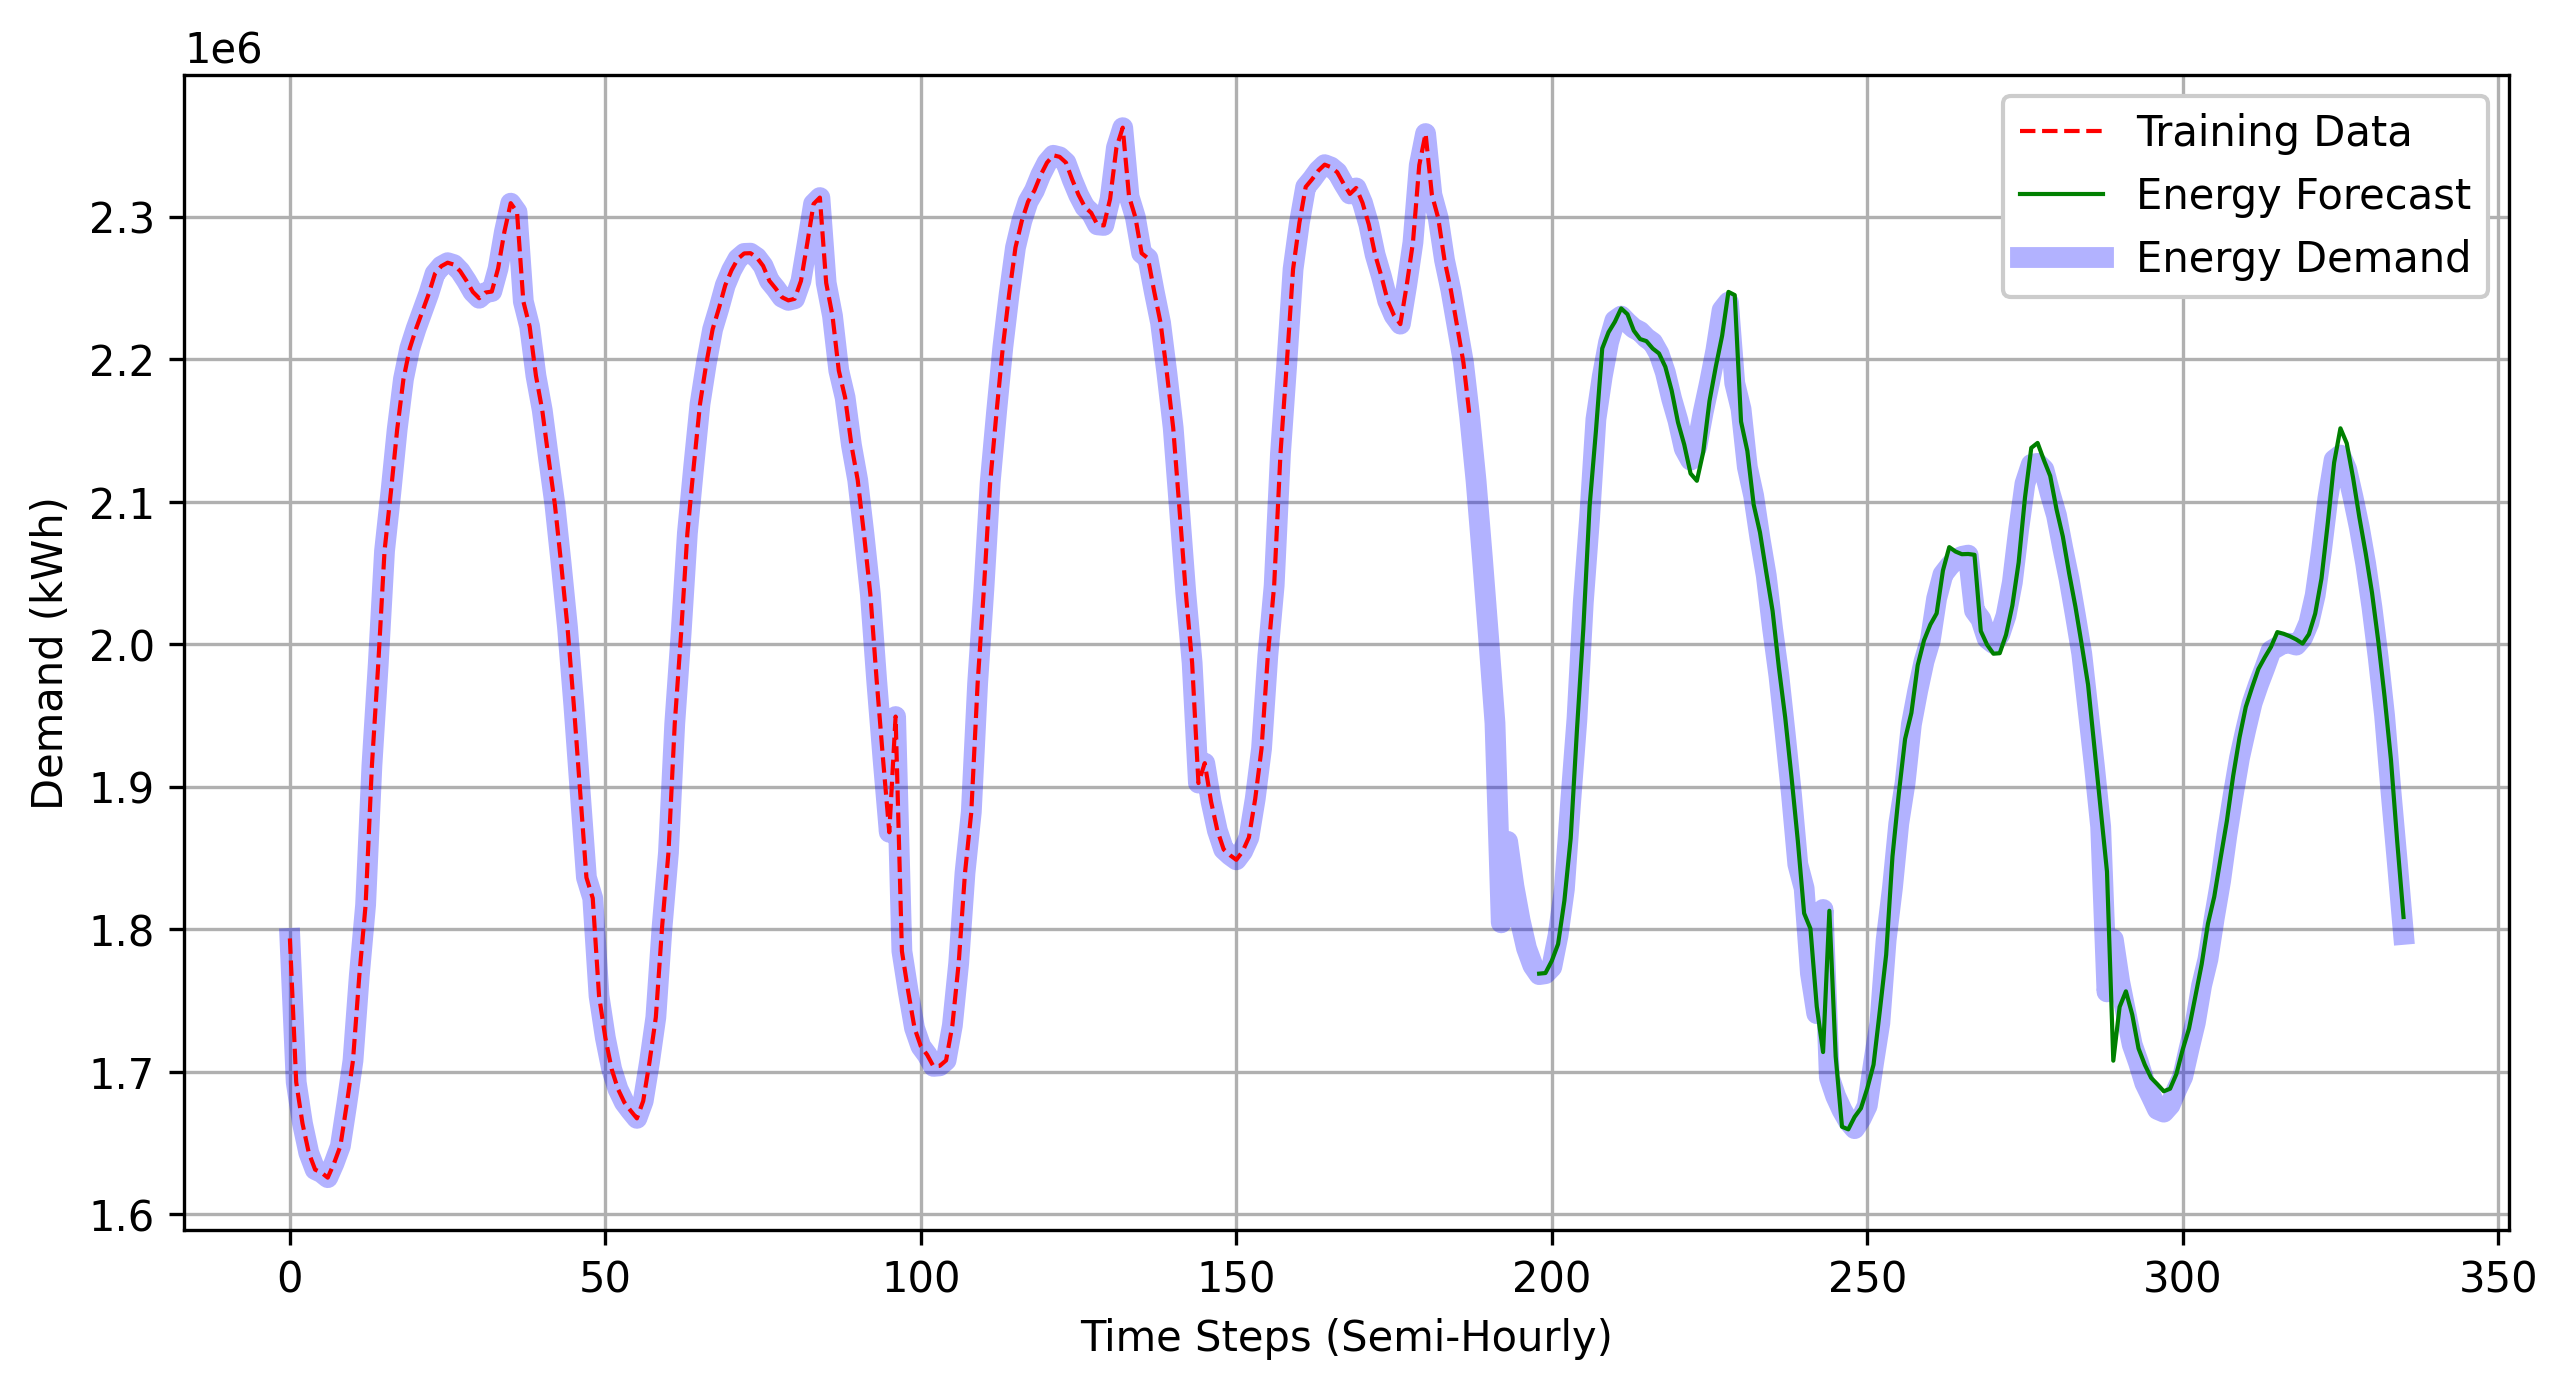

In [32]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_scaled, c='r', linewidth=1, linestyle='--', label='Training Data', zorder=3)
plt.plot(test_scaled, c='g', linewidth=1, label='Energy Forecast', zorder=2)
plt.plot(timeseries, c='b', linewidth=5, alpha=0.3, label='Energy Demand', zorder=1)
plt.xlabel("Time Steps (Semi-Hourly)")
plt.ylabel("Demand (kWh)")
legend = plt.legend(ncols=1)
legend.get_frame().set_alpha(1)  
plt.grid(True, zorder=0)  
plt.gca().set_axisbelow(True)  
plt.show()
